## Imports

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from impedance.models.circuits import CustomCircuit

from scipy.signal import medfilt as medfilt

# from impedance.visualization import plot_nyquist # Kept if you want to switch plotting methods

## Data Loading

In [10]:
# --- Data Loading ---

def lpr_cor_import(filename):
    """ Import cor file as pandas dataframe."""

    try: 
        df = pd.read_csv(
            filename,
            skiprows=26,
            sep='\s+',
            header=None,
            names=["E", "i", "T"],
        ) #index_col="Freq")
    except FileNotFoundError as e:
        print(f"Error: File was not found.")
        print(e.message)
        print(e.args)
        return None
    except Exception as e:
        print(f"Error reading the CSV file: {e}")
        return None   
    else:
        return df

In [11]:
HS1_1 = lpr_cor_import("HIPed_Stellite1_LPR/LPR_1.cor")
HS1_2 = lpr_cor_import("HIPed_Stellite1_LPR/LPR_2.cor")
HS1_3 = lpr_cor_import("HIPed_Stellite1_LPR/LPR_3.cor")
HS1_4 = lpr_cor_import("HIPed_Stellite1_LPR/LPR_4.cor")
HS1_5 = lpr_cor_import("HIPed_Stellite1_LPR/LPR_5.cor")
HS1_6 = lpr_cor_import("HIPed_Stellite1_LPR/LPR_6.cor")


# Keep it in the same cell to keep df reproducible, even if Vi clicks it multiple times
area = 2 #cm^2
kernel_size = 5

for df in [HS1_1, HS1_2, HS1_3, HS1_4, HS1_5, HS1_6]:
    df["i"] = np.abs(df["i"]/area) # Current density


In [12]:
HS1_1

E             i      T
0    -0.206795  7.859750e-11    0.1
1    -0.206805  5.445100e-11    0.2
2    -0.206809  6.106750e-11    0.3
3    -0.206795  5.972600e-11    0.4
4    -0.206780  5.621750e-11    0.5
...        ...           ...    ...
3999 -0.166870  7.752900e-11  400.0
4000 -0.166854  7.931000e-11  400.1
4001 -0.166857  7.781400e-11  400.2
4002 -0.166850  7.296700e-11  400.3
4003 -0.166846  6.987300e-11  400.4

[4004 rows x 3 columns]

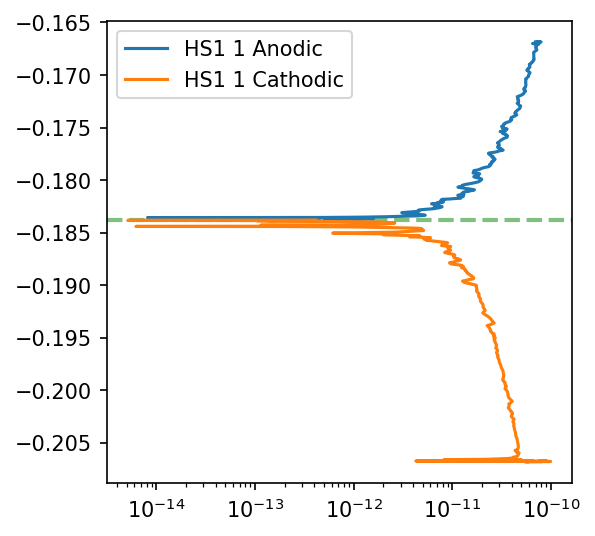

In [13]:
fig, ax = plt.subplots(figsize=(4,4), sharex=True, dpi=150)
kernel_size = 49

# Step 1
# Filter the data a lil bit with a median filter, and find the lowest current, and then find the corresponding voltage
Ecorr_guess = HS1_1['E'].iloc[ np.argmin(medfilt(HS1_1['i'], kernel_size=kernel_size)) ]
ax.axhline(y=Ecorr_guess, color='green', linestyle='--', linewidth=2, alpha=0.5)


# Step 2
# Select data for anodic and cathodic Tafel regions
anodic_df =  HS1_1[HS1_1['E'] > Ecorr_guess] 
cathodic_df =  HS1_1[HS1_1['E'] < Ecorr_guess] 


ax.semilogx(
    np.abs(anodic_df["i"].to_numpy()),
    anodic_df["E"].to_numpy(), 
    markersize=5, label="HS1 1 Anodic")

ax.semilogx(
    np.abs(cathodic_df["i"].to_numpy()),
    cathodic_df["E"].to_numpy(), 
    markersize=5, label="HS1 1 Cathodic")


ax.legend()
plt.show()

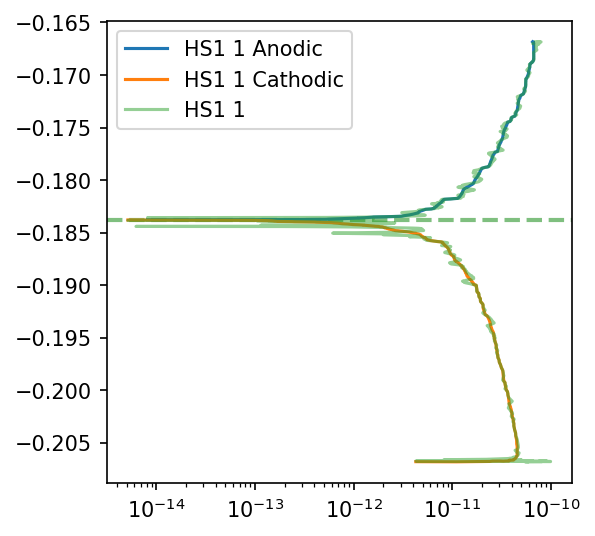

In [14]:
import warnings

fig, ax = plt.subplots(figsize=(4,4), sharex=True, dpi=150)
kernel_size = 49

# Step 1
# Filter the data a lil bit with a median filter, and find the lowest current, and then find the corresponding voltage
Ecorr_guess = HS1_1['E'].iloc[ np.argmin(medfilt(HS1_1['i'], kernel_size=kernel_size)) ]
ax.axhline(y=Ecorr_guess, color='green', linestyle='--', linewidth=2, alpha=0.5)


# Step 2
# Select data for anodic and cathodic Tafel regions
anodic_df =  HS1_1[HS1_1['E'] > Ecorr_guess] 
cathodic_df =  HS1_1[HS1_1['E'] < Ecorr_guess] 

if anodic_df.empty or cathodic_df.empty:
    warnings.warn("Warning: Not enough data for linear Tafel fit.")
    warnings.warn("Your E_corr guess is probably wrong.")
        
# Step 3
# Median filter the hell out of the data, cos it isn't going to change the magnitude of the data :D
kernel_size = 299
medfilt_anodic_df_i = medfilt(anodic_df["i"], kernel_size=kernel_size)
medfilt_cathodic_df_i = medfilt(cathodic_df["i"], kernel_size=kernel_size)

ax.semilogx(
    medfilt_anodic_df_i,
    #np.abs(anodic_df["i"].to_numpy()),
    anodic_df["E"].to_numpy(), 
    markersize=5, label="HS1 1 Anodic")

ax.semilogx(
    medfilt_cathodic_df_i,
    #np.abs(cathodic_df["i"].to_numpy()),
    cathodic_df["E"].to_numpy(), 
    markersize=5, label="HS1 1 Cathodic")

ax.semilogx(
    np.abs(HS1_1['i'].to_numpy()),
    HS1_1["E"].to_numpy(), 
    markersize=5, label="HS1 1", alpha=0.5)

ax.legend()
plt.show()

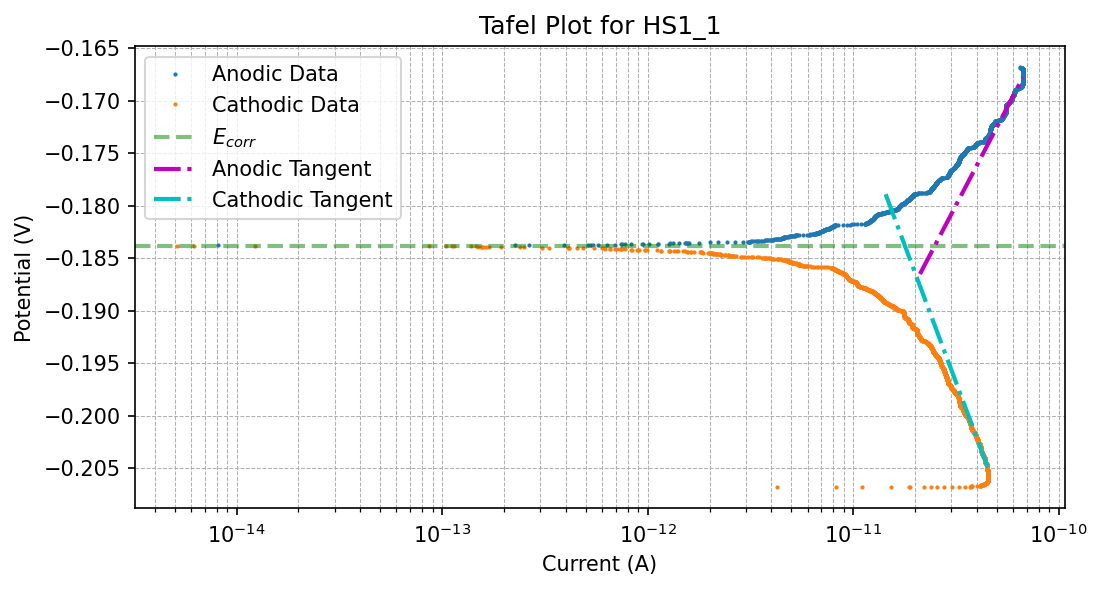

In [20]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt

# --- 1. Initial Setup ---
fig, ax = plt.subplots(figsize=(8, 4), dpi=150)

# --- 2. Data Preparation ---
# Apply a median filter to smooth the current data.
KERNEL_SIZE_INITIAL = 49
filtered_current = medfilt(HS1_1['i'], kernel_size=KERNEL_SIZE_INITIAL)

# Estimate corrosion potential (Ecorr) at the minimum smoothed current.
ecorr_guess_index = np.argmin(filtered_current)
ecorr_guess = HS1_1['E'].iloc[ecorr_guess_index]

# Split data into anodic and cathodic regions based on Ecorr.
anodic_df = HS1_1[HS1_1['E'] > ecorr_guess]
cathodic_df = HS1_1[HS1_1['E'] < ecorr_guess]

if anodic_df.empty or cathodic_df.empty:
    warnings.warn("Insufficient data for Tafel fit. Ecorr guess may be incorrect.")

# --- 3. Advanced Filtering and Curve Fitting ---
# Apply a stronger median filter for cleaner fitting.
KERNEL_SIZE_FIT = 299
medfilt_anodic_i = medfilt(anodic_df["i"], kernel_size=KERNEL_SIZE_FIT)
medfilt_cathodic_i = medfilt(cathodic_df["i"], kernel_size=KERNEL_SIZE_FIT)

# Perform linear fit on E vs. current (for semilog plot).
p_anodic = np.poly1d(np.polyfit(medfilt_anodic_i, anodic_df["E"], 1))
p_cathodic = np.poly1d(np.polyfit(medfilt_cathodic_i, cathodic_df["E"], 1))

# --- 4. Plotting ---
# Plot filtered experimental data.
ax.semilogx(medfilt_anodic_i, anodic_df["E"], 'o', markersize=1, label="Anodic Data")
ax.semilogx(medfilt_cathodic_i, cathodic_df["E"], 'o', markersize=1, label="Cathodic Data")

# Plot Ecorr and Tafel fit lines.
ax.axhline(y=ecorr_guess, color='green', linestyle='--', linewidth=2, alpha=0.5, label='$E_{corr}$')
i_anodic_fit = np.linspace(medfilt_anodic_i.min(), medfilt_anodic_i.max(), 100)
#ax.plot(i_anodic_fit, p_anodic(i_anodic_fit), 'r--', label='Anodic Fit')
i_cathodic_fit = np.linspace(medfilt_cathodic_i.min(), medfilt_cathodic_i.max(), 100)
#ax.plot(i_cathodic_fit, p_cathodic(i_cathodic_fit), 'b--', label='Cathodic Fit')

# --- 5. Tangent Line Calculation and Plotting ---
# Anodic Tangent
i_extreme_anodic = medfilt_anodic_i.max()
E_extreme_anodic = p_anodic(i_extreme_anodic)
tangent_slope_anodic = p_anodic.coeffs[0] * (i_extreme_anodic * np.log(10))
log_i_extreme_anodic = np.log10(i_extreme_anodic)
log_i_tangent_anodic = np.linspace(log_i_extreme_anodic - 0.5, log_i_extreme_anodic, 100)
E_tangent_anodic = tangent_slope_anodic * (log_i_tangent_anodic - log_i_extreme_anodic) + E_extreme_anodic
ax.plot(10**log_i_tangent_anodic, E_tangent_anodic, 'm', linestyle='-.', linewidth=2, label='Anodic Tangent')

# Cathodic Tangent
i_extreme_cathodic = medfilt_cathodic_i.max()
E_extreme_cathodic = p_cathodic(i_extreme_cathodic)
tangent_slope_cathodic = p_cathodic.coeffs[0] * (i_extreme_cathodic * np.log(10))
log_i_extreme_cathodic = np.log10(i_extreme_cathodic)
log_i_tangent_cathodic = np.linspace(log_i_extreme_cathodic - 0.5, log_i_extreme_cathodic, 100)
E_tangent_cathodic = tangent_slope_cathodic * (log_i_tangent_cathodic - log_i_extreme_cathodic) + E_extreme_cathodic
ax.plot(10**log_i_tangent_cathodic, E_tangent_cathodic, 'c', linestyle='-.', linewidth=2, label='Cathodic Tangent')

# --- 6. Final Configuration ---
# Configure plot aesthetics.
ax.set_xlabel("Current (A)")
ax.set_ylabel("Potential (V)")
ax.set_title("Tafel Plot for HS1_1")
ax.legend()
ax.grid(True, which="both", ls="--", linewidth=0.5)

plt.show()

[ 2.42916762e+08 -1.84040974e-01]
[-4.99294175e+08 -1.82337841e-01]


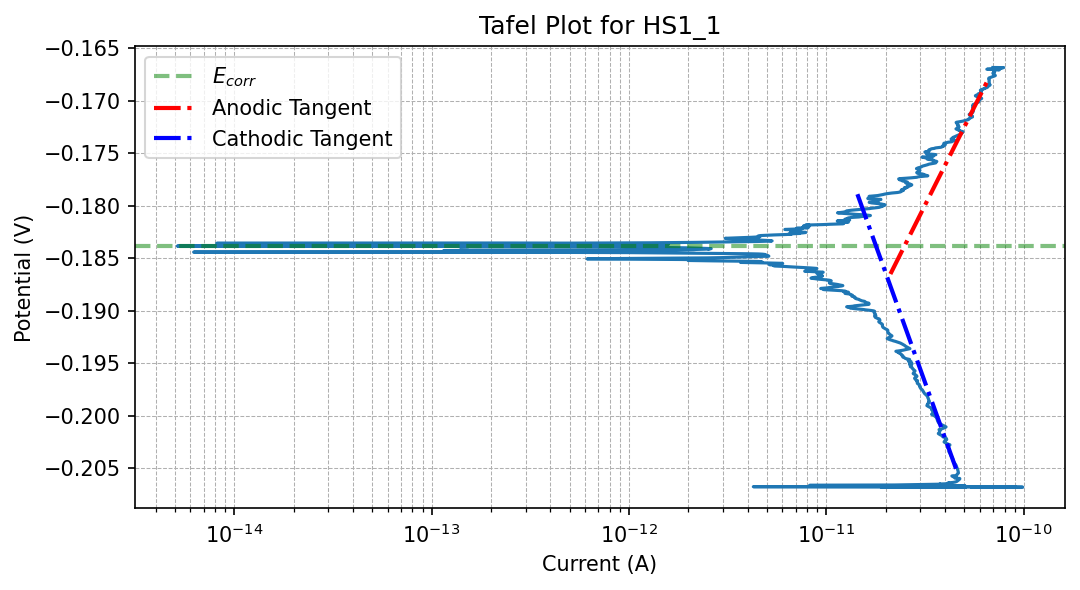

In [37]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt

def analyze_tafel_data(df):

    INITIAL_KERNEL=49
    FIT_KERNEL=299
    
    # 1. Estimate Corrosion Potential (Ecorr)
    filtered_current = medfilt(df['i'], kernel_size=INITIAL_KERNEL)
    ecorr_guess_index = np.argmin(filtered_current)
    ecorr_guess = df['E'].iloc[ecorr_guess_index]

    # 2. Split data into anodic and cathodic regions
    anodic_df = df[df['E'] > ecorr_guess]
    cathodic_df = df[df['E'] < ecorr_guess]

    if anodic_df.empty or cathodic_df.empty:
        warnings.warn("Insufficient data for Tafel fit. Ecorr guess may be incorrect.")
        return None

    # 3. Apply a stronger filter for cleaner fitting
    medfilt_anodic_i = medfilt(anodic_df['i'], kernel_size=FIT_KERNEL)
    medfilt_cathodic_i = medfilt(cathodic_df['i'], kernel_size=FIT_KERNEL)

    # 4. Perform linear fit and generate points for the fit line
    coeff_anodic = np.polyfit(medfilt_anodic_i, anodic_df['E'], 1)    
    p_anodic = np.poly1d(np.polyfit(medfilt_anodic_i, anodic_df['E'], 1))
    i_anodic_fit = np.linspace(medfilt_anodic_i.min(), medfilt_anodic_i.max(), 100)
    E_anodic_fit = p_anodic(i_anodic_fit)

    coeff_cathodic = np.polyfit(medfilt_cathodic_i, cathodic_df['E'], 1)
    p_cathodic = np.poly1d(np.polyfit(medfilt_cathodic_i, cathodic_df['E'], 1))
    i_cathodic_fit = np.linspace(medfilt_cathodic_i.min(), medfilt_cathodic_i.max(), 100)
    E_cathodic_fit = p_cathodic(i_cathodic_fit)

    # 5. Calculate tangent lines
    i_extreme_anodic = medfilt_anodic_i.max()
    E_extreme_anodic = p_anodic(i_extreme_anodic)
    tangent_slope_anodic = p_anodic.coeffs[0] * (i_extreme_anodic * np.log(10))
    log_i_extreme_anodic = np.log10(i_extreme_anodic)
    log_i_tangent_anodic = np.linspace(log_i_extreme_anodic - 0.5, log_i_extreme_anodic, 100)
    E_tangent_anodic = tangent_slope_anodic * (log_i_tangent_anodic - log_i_extreme_anodic) + E_extreme_anodic

    i_extreme_cathodic = medfilt_cathodic_i.max()
    E_extreme_cathodic = p_cathodic(i_extreme_cathodic)
    tangent_slope_cathodic = p_cathodic.coeffs[0] * (i_extreme_cathodic * np.log(10))
    log_i_extreme_cathodic = np.log10(i_extreme_cathodic)
    log_i_tangent_cathodic = np.linspace(log_i_extreme_cathodic - 0.5, log_i_extreme_cathodic, 100)
    E_tangent_cathodic = tangent_slope_cathodic * (log_i_tangent_cathodic - log_i_extreme_cathodic) + E_extreme_cathodic

    print(coeff_anodic)
    print(coeff_cathodic)
    
    # 6. Package results into a dictionary
    results = {
        "ecorr_guess": ecorr_guess,
        "anodic_tangent_i": 10**log_i_tangent_anodic,
        "anodic_tangent_E": E_tangent_anodic,
        "cathodic_tangent_i": 10**log_i_tangent_cathodic,
        "cathodic_tangent_E": E_tangent_cathodic,
    }
    return results

# =============================================================================
# --- Global Namespace: Analysis and Plotting ---
# =============================================================================

# 1. Analyze the dataset
analysis_results = analyze_tafel_data(HS1_1)

# 2. Set up the plot
fig, ax = plt.subplots(figsize=(8, 4), dpi=150)
ax.set_xscale('log') # Set x-axis to log scale

ax.semilogx(
    np.abs(HS1_1["i"].to_numpy()),
    HS1_1["E"].to_numpy(), 
    markersize=5)

# 3. Plot all data if analysis was successful
if analysis_results:
    # Plot Ecorr
    ax.axhline(
        y=analysis_results["ecorr_guess"],
        color='green', linestyle='--', linewidth=2, alpha=0.5, label='$E_{corr}$'
    )

    # Plot tangent lines
    ax.plot(
        analysis_results["anodic_tangent_i"],
        analysis_results["anodic_tangent_E"],
        'r', linestyle='-.', linewidth=2, label='Anodic Tangent'
    )
    ax.plot(
        analysis_results["cathodic_tangent_i"],
        analysis_results["cathodic_tangent_E"],
        'b', linestyle='-.', linewidth=2, label='Cathodic Tangent'
    )

    # 4. Configure final plot aesthetics
    ax.set_xlabel("Current (A)")
    ax.set_ylabel("Potential (V)")
    ax.set_title("Tafel Plot for HS1_1")
    ax.legend()
    ax.grid(True, which="both", ls="--", linewidth=0.5)

    plt.show()

In [ ]:


def analyze_tafel_data(
    data: pd.DataFrame
) -> dict | None:

    INITIAL_KERNEL = 49
    FIT_KERNEL = 49
    
    # 1. Estimate Corrosion Potential (Ecorr) using a median filter
    filtered_current = medfilt(data['i'], kernel_size=INITIAL_KERNEL)
    ecorr_guess_index = np.argmin(filtered_current)
    ecorr_guess = data['E'].iloc[ecorr_guess_index]

    # 2. Split data into anodic and cathodic regions based on Ecorr
    anodic_data = data[data['E'] > ecorr_guess]
    cathodic_data = data[data['E'] < ecorr_guess]

    # 3. Apply a stronger filter for a cleaner linear fit
    medfilt_anodic_i = medfilt(anodic_data['i'].iloc[30:-30], kernel_size=FIT_KERNEL)
    medfilt_cathodic_i = medfilt(cathodic_data['i'].iloc[30:-30], kernel_size=FIT_KERNEL)

    # 4. Perform linear fit on E vs. i for each branch
    p_anodic = np.poly1d(np.polyfit(medfilt_anodic_i, anodic_data['E'].iloc[30:-30], 1))
    p_cathodic = np.poly1d(np.polyfit(medfilt_cathodic_i, cathodic_data['E'].iloc[30:-30], 1))

    # 5. Calculate tangent lines at the extreme ends of the filtered data
    # NOTE: The following tangent slope calculation is preserved from the original script.
    i_extreme_anodic = medfilt_anodic_i.max()
    e_extreme_anodic = p_anodic(i_extreme_anodic)
    tangent_slope_anodic = p_anodic.coeffs[0] * (i_extreme_anodic * np.log(10))

    log_i_extreme_anodic = np.log10(i_extreme_anodic)
    log_i_tangent_anodic = np.linspace(log_i_extreme_anodic - 0.5, log_i_extreme_anodic, 100)
    e_tangent_anodic = (
        tangent_slope_anodic * (log_i_tangent_anodic - log_i_extreme_anodic)
        + e_extreme_anodic
    )

    i_extreme_cathodic = medfilt_cathodic_i.max()
    e_extreme_cathodic = p_cathodic(i_extreme_cathodic)
    tangent_slope_cathodic = p_cathodic.coeffs[0] * (i_extreme_cathodic * np.log(10))

    log_i_extreme_cathodic = np.log10(i_extreme_cathodic)
    log_i_tangent_cathodic = np.linspace(log_i_extreme_cathodic - 0.5, log_i_extreme_cathodic, 100)
    e_tangent_cathodic = (
        tangent_slope_cathodic * (log_i_tangent_cathodic - log_i_extreme_cathodic)
        + e_extreme_cathodic
    )

    # 6. Package results into a dictionary
    results = {
        "ecorr_guess": ecorr_guess,
        "beta_a": -p_anodic.coeffs[1],        
        "beta_c": p_cathodic.coeffs[1],
        "anodic_tangent_i": 10**log_i_tangent_anodic,
        "anodic_tangent_E": e_tangent_anodic,
        "cathodic_tangent_i": 10**log_i_tangent_cathodic,
        "cathodic_tangent_E": e_tangent_cathodic,
    }
    return results


In [76]:

def plot_tafel(data: pd.DataFrame, results: dict, title: str):
    """
    Generates and displays a Tafel plot from the data and analysis results.

    Args:
        data (pd.DataFrame): The original experimental data.
        results (dict): The dictionary returned by analyze_tafel_data.
        title (str): The title for the plot.
    """
    fig, ax = plt.subplots(figsize=(8, 4), dpi=150)

    # Plot the raw experimental data
    ax.semilogx(
        np.abs(data["i"].to_numpy()),
        data["E"].to_numpy(),
        marker='o',
        linestyle='',
        markersize=3,
        alpha=0.6,
        label="Experimental Data"
    )

    # Plot the analysis results if available
    if results:
        # Ecorr line
        ax.axhline(
            y=results["ecorr_guess"],
            color='green',
            linestyle='--',
            linewidth=2,
            label=f'$E_{{corr}}$ = {results["ecorr_guess"]:.3f} V'
        )
        # Anodic tangent line
        ax.plot(
            results["anodic_tangent_i"],
            results["anodic_tangent_E"],
            color='red',
            linestyle='-.',
            linewidth=2,
            label=f'Anodic Tangent {results["beta_a"]}'
        )
        # Cathodic tangent line
        ax.plot(
            results["cathodic_tangent_i"],
            results["cathodic_tangent_E"],
            color='blue',
            linestyle='-.',
            linewidth=2,
            label=f'Cathodic Tangent {results["beta_c"]}'
        )

    # Configure plot aesthetics
    ax.set_xlabel("Absolute Current (A)")
    ax.set_ylabel("Potential (V)")
    ax.set_title(title)
    ax.legend()
    ax.grid(True, which="both", ls="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()





beta_a 0.1839147086435225
beta_c -0.1821741558893317


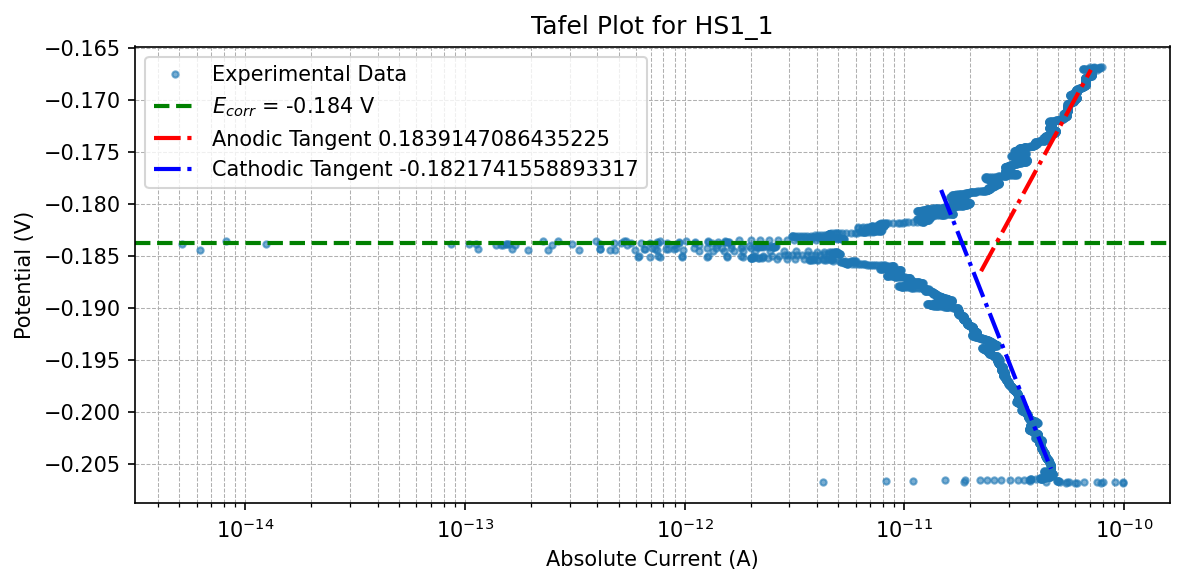

In [77]:
# =============================================================================
# --- Main Execution Block ---
# =============================================================================

# 1. Analyze the dataset
analysis_results = analyze_tafel_data(HS1_1)
print(f"beta_a {analysis_results['beta_a']}")
print(f"beta_c {analysis_results['beta_c']}")

# 2. Plot the results
if analysis_results:
    plot_tafel(HS1_1, analysis_results, title="Tafel Plot for HS1_1")
else:
    print("Analysis could not be completed.")


In [78]:
import math

# --- 1. Define Physical Constants ---
R = 8.314  # Ideal Gas Constant (J/(mol·K))
F = 96485  # Faraday Constant (C/mol)
n = 2 # Number of electrons transferred in your electrochemical reaction.

# --- 2. Provide Your Experimental Data Here ---
anodic_slope = 0.038  # Example value in V/decade, replace with your own.
cathodic_slope = -0.0538 # Example value in V/decade, replace with your own.

# --- 3. Calculations ---
# The temperature at which the experiment was conducted.
temp_kelvin = 25.0 + 273.15


# Calculate the anodic charge transfer coefficient (alpha_a)
# This value represents the fraction of the potential that assists the oxidation reaction.
try:
    alpha_a = (2.303 * R * temp_kelvin) / (anodic_slope * n * F)
    alpha_c = -(2.303 * R * temp_kelvin) / (cathodic_slope * n * F)    
except ZeroDivisionError as e:
    print("Slope is zero, what happened?")
    print(e)
    

# --- 4. Display the Results ---
print("--- Butler-Volmer Kinetic Parameters ---")
print(f"Anodic Charge Transfer Coefficient (α_a): {alpha_a:.4f}")
print(f"Cathodic Charge Transfer Coefficient (α_c): {alpha_c:.4f}")
print("\n--- Next Step: Finding the Exchange Current Density (j₀) ---")
print("The exchange current density (j₀) is found from your Tafel plot.")
print("It is the current density value where the anodic and cathodic tangent lines intersect.")
print("This point corresponds to the equilibrium potential (where overpotential η = 0).")



--- Butler-Volmer Kinetic Parameters ---
Anodic Charge Transfer Coefficient (α_a): 0.7785
Cathodic Charge Transfer Coefficient (α_c): 0.5499

--- Next Step: Finding the Exchange Current Density (j₀) ---
The exchange current density (j₀) is found from your Tafel plot.
It is the current density value where the anodic and cathodic tangent lines intersect.
This point corresponds to the equilibrium potential (where overpotential η = 0).
